توجه: فقط قسمت های خواسته شده را تکمیل کنید و همراه فایل خود مدل آموزش دیده را ارسال کنید.

هدف این تمرین :


1.   ساخت دیتاست مورد نیاز و نوشتن کلاس دیتاست
2.   Augmentation
3.   نوشتن مدل دسته بندی 3 کلاسه با استفاده از چند کلاس پایتون



In [1]:
## download data
%%capture

!wget http://data.csail.mit.edu/places/ADEchallenge/release_test.zip
!wget http://data.csail.mit.edu/places/ADEchallenge/ADEChallengeData2016.zip
!unzip ADEChallengeData2016.zip
!unzip release_test.zip
!pip install mmengine

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import glob

from cv2 import imread as IM
from os import path

from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import random
from torch.utils.data import random_split

from random import randint
import matplotlib.pyplot as plt
from PIL import Image

## Data Generation

در این قسمت برای ساخت دیتاست مورد نیاز باید از هر تصویر دانلود شده ،2 تصویر یکی بدون تغییر و دیگری تغییر یافته به سایز 224 در 224 تولید کنید .به این منظور ابتداتابع های 1تا 6 را کامل کرده و سپس از تابع های 1تا3 برای ساخت تصویر تغییر یافته استفاده کنید.توجه داشته باشید که در تصاویر تولیدی تعدادی فقط یک تغییر و تعدادی دو و سه تغییر را باید داشته باشند،همچنین در تصاویر تولید شده نباید قسمت مشکی ناشی از چرخش وجود داشته باشد




In [3]:
# Function 1: Displacement
def displacement(img):
    # Example: Shift the image horizontally or vertically by a random amount
    max_displacement = 10
    dx, dy = random.randint(-max_displacement, max_displacement), random.randint(-max_displacement, max_displacement)
    img = np.roll(img, (dx, dy), axis=(0, 1))
    return img

# Function 2: Rotation
def rotation(img):
    # Example: Rotate the image by a random angle
    angle = random.randint(-45, 45)

    # Get image dimensions
    height, width = img.shape[:2]

    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)

    # Determine the new dimensions of the rotated image
    cos_theta = np.abs(rotation_matrix[0, 0])
    sin_theta = np.abs(rotation_matrix[0, 1])
    new_width = int((width * cos_theta) + (height * sin_theta))
    new_height = int((width * sin_theta) + (height * cos_theta))

    # Adjust the rotation matrix to prevent cropping
    rotation_matrix[0, 2] += (new_width - width) / 2
    rotation_matrix[1, 2] += (new_height - height) / 2

    # Apply rotation without black parts
    rotated_img = cv2.warpAffine(img, rotation_matrix, (new_width, new_height), borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

    return rotated_img

# Function 3: Scaling
def scaling(img):
    # Example: Resize the image to 224x224
    img = transforms.functional.resize(Image.fromarray(img), (224, 224))
    return np.array(img)

# Function 4: Brightness
def brightness(img):
    # Example: Adjust brightness by a random factor
    factor = random.uniform(0.5, 1.5)
    img = transforms.functional.adjust_brightness(Image.fromarray(img), factor)
    return np.array(img)

# Function 5: Blurring
def blurring(img):
    # Example: Apply Gaussian blur
    img = cv2.GaussianBlur(img, (5, 5), 0)
    return img

# Function 6: Gaussian Noise
def gaussian_noise(img):
    # Example: Add Gaussian noise
    noise = np.random.normal(0, 20, img.shape)
    img = img + noise
    return np.clip(img, 0, 255)





In [21]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, file_path = None, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.test = 0
        try:
            with open(file_path, 'r') as file:
                lines = file.readlines()
            self.data = [line.strip().split() for line in lines]
            self.labels = [int(label) for _, label in self.data]
        except:
            self.data = [line.strip().split() for line in lines]
            self.test = 1

    def __getitem__(self, idx):
        if self.test == 0:
            image_name, label = self.data[idx]
            img_path = self.image_paths + "/" +image_name
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            original_img = img.copy()
        else:
            img_path = self.image_paths[idx]
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            original_img = img.copy()
            label = 0


        # Apply random transformations
        num_transforms = random.randint(1, 3)
        for _ in range(num_transforms):
            transform = random.choice(self.transform)
            img = transform(img)

        # Resize the image to a fixed size
        img = cv2.resize(img, (224, 224))

        a = ToTensor()

        img = a(img)

        return img, label

    def __len__(self):
        return len(self.image_paths)



In [22]:
# Set the paths to the downloaded dataset
data_root_train = "ADEChallengeData2016/images/training"
data_root_test = "release_test/testing"
data_root_val = "ADEChallengeData2016/images/validation"

# Get the list of all image files in the dataset
all_image_paths1 = [os.path.join(data_root_train, img) for img in os.listdir(data_root_train) if img.endswith(('.jpg'))]

# Get the list of all image files in the dataset
all_image_paths2 = [os.path.join(data_root_test, img) for img in os.listdir(data_root_test) if img.endswith(('.jpg'))]

# Get the list of all image files in the dataset
all_image_paths3 = [os.path.join(data_root_val, img) for img in os.listdir(data_root_val) if img.endswith(('.jpg'))]

dataset_train = CustomDataset(all_image_paths1,"ADEChallengeData2016/sceneCategories.txt",[displacement, rotation, scaling])## To Do
dataset_test = CustomDataset(all_image_paths2,"release_test/list.txt",[displacement, rotation, scaling])## To Do
dataset_val = CustomDataset(all_image_paths3,"ADEChallengeData2016/sceneCategories.txt",[displacement, rotation, scaling])## To Do

train_loader = DataLoader(dataset_train, batch_size=8, shuffle=True)## To Do
test_loader= DataLoader(dataset_test, batch_size=8, shuffle=True)## To Do
val_loader = DataLoader(dataset_val, batch_size=8, shuffle=True)## To Do


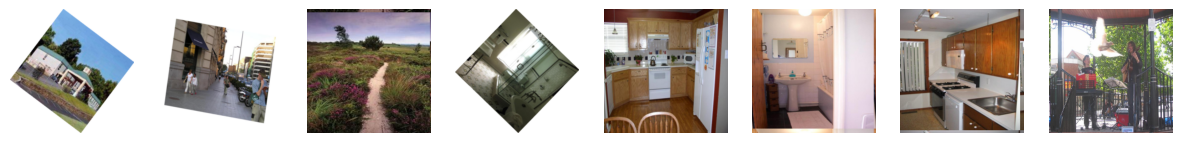

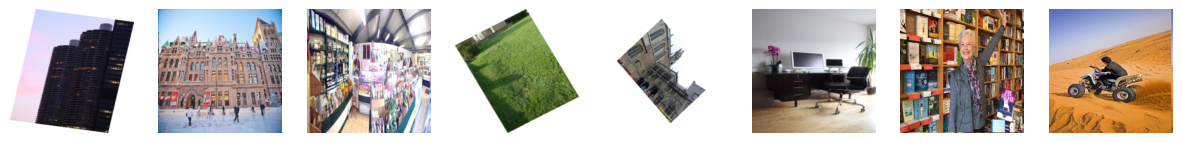

In [20]:
## To Do  : show 8 images from train_loader & 8 images from test_loader
# Display image and label.
train_features,label = next(iter(train_loader))
img = train_features.squeeze()

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, (img, ax) in enumerate(zip(img, axes)):
    ax.imshow(img)
    ax.axis('off')

plt.show()

test_features,la = next(iter(test_loader))
img = test_features.squeeze()

fig, axes = plt.subplots(1, 8, figsize=(15, 5))
for i, (img, ax) in enumerate(zip(img, axes)):
    ax.imshow(img)
    ax.axis('off')

plt.show()



##Model

در این قسمت میخواهیم یک مدل 3 کلاسه  مطبق شکل زیرکه شامل قسمت های زیر میشود را آموزش دهیم.

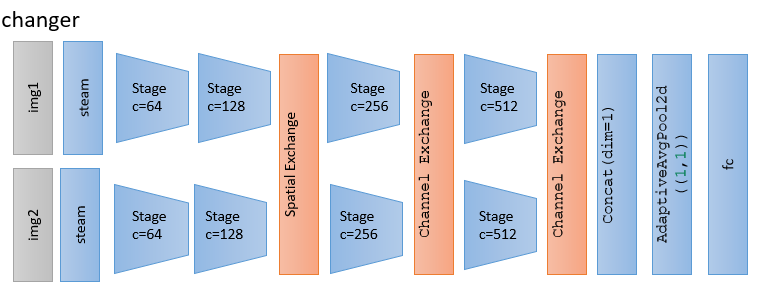

دو کلاس



1.   SpatialExchange
2.   ChannelExchange


 .مطابق شکل زیر ویژگی های دو تصویر را با هم عوض میکنند.


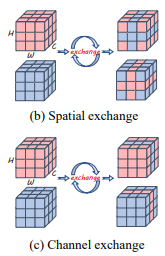

In [23]:
## dont change this block

from mmengine.model import BaseModule
class ChannelExchange(BaseModule):
    """
    channel exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape

        exchange_map = torch.arange(c) % self.p == 0
        exchange_mask = exchange_map.unsqueeze(0).expand((N, -1))

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[~exchange_mask, ...] = x1[~exchange_mask, ...]
        out_x2[~exchange_mask, ...] = x2[~exchange_mask, ...]
        out_x1[exchange_mask, ...] = x2[exchange_mask, ...]
        out_x2[exchange_mask, ...] = x1[exchange_mask, ...]

        return out_x1, out_x2



class SpatialExchange(BaseModule):
    """
    spatial exchange
    Args:
        p (float, optional): p of the features will be exchanged.
            Defaults to 1/2.
    """
    def __init__(self, p=1/2):
        super().__init__()
        assert p >= 0 and p <= 1
        self.p = int(1/p)

    def forward(self, x1, x2):
        N, c, h, w = x1.shape
        exchange_mask = torch.arange(w) % self.p == 0

        out_x1, out_x2 = torch.zeros_like(x1), torch.zeros_like(x2)
        out_x1[..., ~exchange_mask] = x1[..., ~exchange_mask]
        out_x2[..., ~exchange_mask] = x2[..., ~exchange_mask]
        out_x1[..., exchange_mask] = x2[..., exchange_mask]
        out_x2[..., exchange_mask] = x1[..., exchange_mask]

        return out_x1, out_x2

شبکه ی زیر را پیاده کنید  

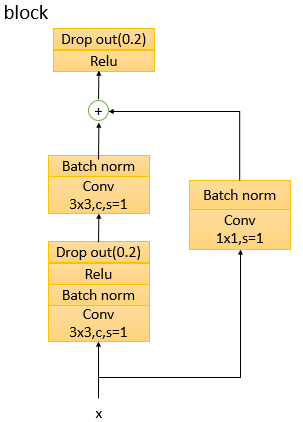

سوال تئوری1:
1.  مقادیر زیر را برای لایه های کانولوشن چه قدر در نظر گرفته اید؟
 channel out size (conv(1*1))
 padding(conv)
2.  دلیل استفاده از کانولوشن 1در1 چیست؟





<h1>
answer:
</h1>
<p dir="rtl">
سوال 1:
برای حفظ سایز تصاویر و انجام روش same به تعداد یک عدد کمتر از سایز کرنل پدیتنگ انجام شده
<br>
سوال 2:
از بین بردن عمق و تعداد کانال های تصویر ورودی
</p>

In [24]:
##To Do
class block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(block,self).__init__()
        # First block
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout2d(0.2)

        # Second block with residual connection
        self.conv2a = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.batch_norm2a = nn.BatchNorm2d(out_channels)

        # Shortcut path
        self.conv2b = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
        self.batch_norm2b = nn.BatchNorm2d(out_channels)

        # Final block
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout2d(0.2)


    def forward(self,x):
        # First block
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        # Second block with residual connection
        out_a = self.conv2a(out)
        out_a = self.batch_norm2a(out_a)

        # Shortcut path
        out_b = self.conv2b(x)
        out_b = self.batch_norm2b(out_b)

        # Element-wise addition
        out = out_a + out_b

        # Final block
        out = self.relu2(out)
        out = self.dropout2(out)


        return out

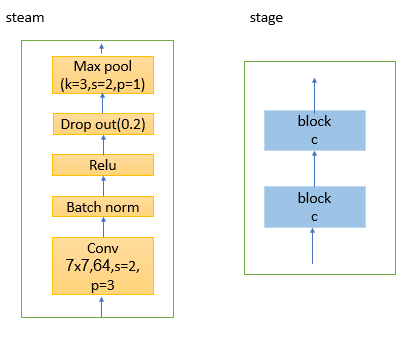

با استفاده از تصاویر مدل ،کلاس زیر را تکمیل کنید.

In [25]:
#To Do
class changer(nn.Module):
  def __init__(self,SpatialExchange,ChannelExchange):
    super(changer,self).__init__()

    self.steam=nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout2d(0.2),
        nn.MaxPool2d(3,2,1)
        )

    b1 = block(64,64)
    self.stage1=nn.Sequential(
        b1,
        b1
    )

    b2 = block(64,128)
    b21 = block(64,64)
    self.stage2=nn.Sequential(
        b21,
        b2
    )

    b3 = block(128,256)
    b31 = block(128,128)
    self.stage3=nn.Sequential(
        b31,
        b3
    )

    b4 = block(256,512)
    b41 = block(256,256)
    self.stage4=nn.Sequential(
        b41,
        b4
    )

    self.SpatialExchange = SpatialExchange()
    self.ChannelExchange = ChannelExchange()

    self.adaptive_avgpool = nn.AdaptiveAvgPool2d((1, 1))

    self.flat = nn.Flatten()

    self.fc = nn.Linear(1024,3)

  def forward(self,x1,x2):
    #PATH1-1
    out1 = self.steam(x1)
    out1 = self.stage1(out1)
    out1 = self.stage2(out1)
    #PATH2-1
    out2 = self.steam(x2)
    out2 = self.stage1(out2)
    out2 = self.stage2(out2)
    #SpatialExchange
    out1, out2 = self.SpatialExchange(out1,out2)
    #PATH1-2
    out1 = self.stage3(out1)

    #PATH2-2
    out2 = self.stage3(out2)

    #ChannelExchange
    out1, out2 = self.ChannelExchange(out1,out2)

    #PATH1-3
    out1 = self.stage4(out1)

    #PATH2-3
    out2 = self.stage4(out2)

    #ChannelExchange
    out1, out2 = self.ChannelExchange(out1,out2)

    #concat
    result = torch.cat((out1, out2), dim=1)

    # Apply Adaptive Average Pooling to the input tensor
    result = self.adaptive_avgpool(result)

    result = self.flat(result)
    out = self.fc(result)

    return out

In [26]:
## To Do
device = "cpu"

model=changer(SpatialExchange,ChannelExchange).to(device)

citeration = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

##Train & validation


In [ ]:
from logging import critical

Loss_train=[]
Loss_val=[]

def train_loop(dataloader, model, loss_fn, optimizer):
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X1, y1) in enumerate(dataloader):
        for batch, (X2, y2) in enumerate(dataloader):
                # Compute prediction and loss
                pred = model(X1.float(),X2.float())
                loss = loss_fn(pred, y1)

                # Backpropagation
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                if batch % 100 == 0:
                    loss, current = loss.item(), (batch + 1) * len(X1)
                    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, citeration , optimizer)

# print(f'loss_TRAIN ={Sum_loss:.3f},acc_train={(num_correct_train)},\t loss_val= {loss_val:.3f}, acc_val={(num_correct_val)}')



#Test


In [ ]:
def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        test_loss += citeration(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

num_batches = len(test_loader)
test_loss /= num_batches
size = len(test_loader.dataset)
correct /= size
print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


سوال تئوری:
بررسی کنید عکس ها با یک ،2 یا 3 تغییر کدام بهتر تشخیص داده میشوند؟